In [1]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
advanced_df = pd.read_csv('/Users/alexmerdjanian/Desktop/NBA project/nba_data/Advanced.csv')
award_shares_df = pd.read_csv('/Users/alexmerdjanian/Desktop/NBA project/nba_data/Player Award Shares.csv')

In [2]:
print(advanced_df.columns)
print(award_shares_df.columns)

Index(['seas_id', 'season', 'player_id', 'player', 'birth_year', 'pos', 'age',
       'experience', 'lg', 'tm', 'g', 'mp', 'per', 'ts_percent', 'x3p_ar',
       'f_tr', 'orb_percent', 'drb_percent', 'trb_percent', 'ast_percent',
       'stl_percent', 'blk_percent', 'tov_percent', 'usg_percent', 'ows',
       'dws', 'ws', 'ws_48', 'obpm', 'dbpm', 'bpm', 'vorp'],
      dtype='object')
Index(['season', 'award', 'player', 'age', 'tm', 'first', 'pts_won', 'pts_max',
       'share', 'winner', 'seas_id', 'player_id'],
      dtype='object')


In [3]:
# Merge on player and season
award_shares_df = award_shares_df.rename(columns={'Player': 'player', 'Season': 'season'})
advanced_df = advanced_df.rename(columns={'player': 'player', 'season': 'season'})
merged_df = pd.merge(advanced_df, award_shares_df, on=['player', 'season'], how='left')
merged_df.head

<bound method NDFrame.head of        seas_id_x  season  player_id_x          player  birth_year  pos  age_x  \
0        31871.0    2025       5025.0      A.J. Green         NaN   SG   25.0   
1        31872.0    2025       5026.0     A.J. Lawson         NaN   SG   24.0   
2        31873.0    2025       5210.0      AJ Johnson         NaN   SG   20.0   
3        31874.0    2025       5210.0      AJ Johnson         NaN   SG   20.0   
4        31875.0    2025       5210.0      AJ Johnson         NaN   SG   20.0   
...          ...     ...          ...             ...         ...  ...    ...   
33149      200.0    1947        157.0     Walt Miller         NaN    F   31.0   
33150      201.0    1947        158.0   Warren Fenley         NaN    F   24.0   
33151      202.0    1947        159.0   Wilbert Kautz         NaN  G-F   31.0   
33152      203.0    1947        160.0  Woody Grimshaw         NaN    G   27.0   
33153      204.0    1947        161.0     Wyndol Gray         NaN  G-F   24.0  

In [4]:
# Filter to MVP shares only (or any other award, if desired)
mvp_df = merged_df[
    (merged_df['season'] >= 2014)
]

In [5]:
winner_counts = mvp_df['winner'].value_counts()
print(winner_counts)

winner
False    784
True      57
Name: count, dtype: int64


In [6]:
# Filter rows where winner and award is 'nba mvp'
mvp_winner = mvp_df[(mvp_df['winner']) & (mvp_df['award'] == 'nba mvp')]
print(mvp_winner)

      seas_id_x  season  player_id_x                 player  birth_year pos  \
1268    31672.0    2024       4352.0           Nikola Jokić         NaN   C   
1792    30765.0    2023       4416.0            Joel Embiid         NaN   C   
2774    30247.0    2022       4352.0           Nikola Jokić         NaN   C   
3512    29456.0    2021       4352.0           Nikola Jokić         NaN   C   
3926    28507.0    2020       4164.0  Giannis Antetokounmpo         NaN  PF   
4593    27807.0    2019       4164.0  Giannis Antetokounmpo         NaN  PF   
5374    27202.0    2018       3880.0           James Harden         NaN  SG   
6264    26813.0    2017       3849.0      Russell Westbrook         NaN  PG   
6897    26259.0    2016       3903.0          Stephen Curry         NaN  PG   
7548    25661.0    2015       3903.0          Stephen Curry         NaN  PG   
7989    24828.0    2014       3770.0           Kevin Durant         NaN  SF   

      age_x  experience   lg tm_x  ...    award  ag

In [7]:
# Add 'mvp_winner' column to all rows, initially set to 0
mvp_df['mvp_winner'] = 0

# Set 'mvp_winner' to 1 for MVP winners
mvp_df.loc[mvp_winner.index, 'mvp_winner'] = 1

mvp_winner_counts = mvp_df['mvp_winner'].value_counts()
mvp_winner_counts

/var/folders/p1/pbj79r650x59h2qrchrzb2140000gn/T/ipykernel_55843/2967352102.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mvp_df['mvp_winner'] = 0


mvp_winner
0    8255
1      11
Name: count, dtype: int64

In [8]:
# Define features (you can adjust based on your dataset)
features = ['bpm', 'vorp', 'ws', 'ts_percent', 'usg_percent', 'per']

# Drop rows where any of the features have missing values
mvp_df_clean = mvp_df.dropna(subset=features)

# Define X (features) and y (target)
X = mvp_df_clean[features]
y = mvp_df_clean['mvp_winner']

In [9]:
from sklearn.model_selection import train_test_split

# Split the data into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
from sklearn.linear_model import LogisticRegression

# Initialize the logistic regression model with balanced class weights
model = LogisticRegression(class_weight='balanced')

# Fit the model to the training data
model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced')

In [11]:
from sklearn.metrics import classification_report

# Predict on the test set
y_pred = model.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1640
           1       0.11      1.00      0.20         1

    accuracy                           1.00      1641
   macro avg       0.56      1.00      0.60      1641
weighted avg       1.00      1.00      1.00      1641



Results: Class imbalance problem; model predicting the majority class perfectly but struggling with the minority class.

Shifting to Random Forest Classifier

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score

In [30]:
# Use the clean mvp_df to define features (X) and target (y)
features = ['bpm', 'vorp', 'ws', 'ts_percent', 'usg_percent', 'per']

# Drop rows where any of the features have missing values
mvp_df_clean = mvp_df.dropna(subset=features)

# Define X (features) and y (target)
X = mvp_df_clean[features]
y = mvp_df_clean['mvp_winner']

In [32]:
# Apply SMOTE to balance the dataset by oversampling the minority class
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [34]:
# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Create a Random Forest classifier with balanced class weights
rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)

# Fit the model
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

In [36]:
# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1654
           1       1.00      1.00      1.00      1624

    accuracy                           1.00      3278
   macro avg       1.00      1.00      1.00      3278
weighted avg       1.00      1.00      1.00      3278



In [38]:
# Check feature importances
importances = rf_model.feature_importances_
print("\nFeature Importances:")
for feature, importance in zip(features, importances):
    print(f"Feature: {feature}, Importance: {importance}")


Feature Importances:
Feature: bpm, Importance: 0.28380037807206193
Feature: vorp, Importance: 0.28189781770591454
Feature: ws, Importance: 0.12182780201116675
Feature: ts_percent, Importance: 0.0009057229503480023
Feature: usg_percent, Importance: 0.09151407304327153
Feature: per, Importance: 0.22005420621723742


In [44]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation
cv_scores = cross_val_score(rf_model, X_resampled, y_resampled, cv=5, scoring='accuracy')
print(f"Cross-validation accuracy scores: {cv_scores}")
print(f"Average accuracy from cross-validation: {cv_scores.mean()}")

Cross-validation accuracy scores: [0.99694936 0.99847468 0.99847468 1.         0.99908453]
Average accuracy from cross-validation: 0.9985966494526256


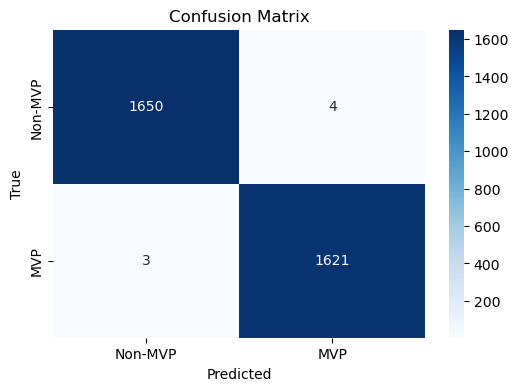

In [48]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate confusion matrix
y_pred = rf_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

# Visualize confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-MVP', 'MVP'], yticklabels=['Non-MVP', 'MVP'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

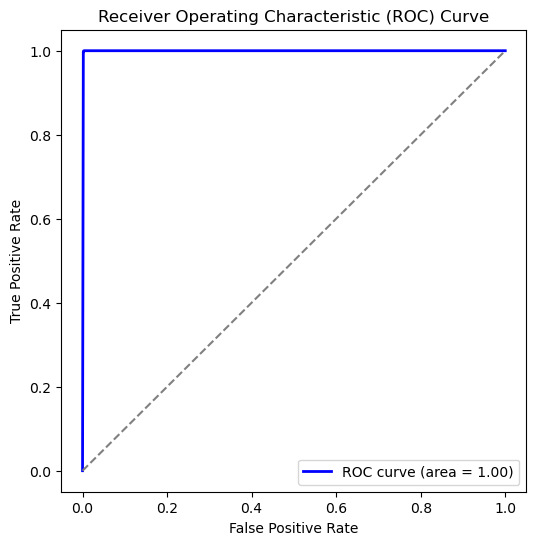

In [50]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, rf_model.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

Excellent accuracy (99.89%) and high precision and recall for both MVP and non-MVP players. This model demonstrates a strong ability to correctly classify MVP winners with minimal errors, suggesting it is highly reliable for predicting MVPs based on performance metrics.